In [15]:
# SHASHANK KATHAVATE
# 2021530332
# ARTIFICIAL INTELLIGENCE - CS6364

The code can be run on GPU or CPU, however the cpu execution take longer. If there is no GPU available please use the same coed on google colab with the GPU enabled. The code requires the files "mnist_train.csv" and "mnist_test.csv" in the same directory to run. The outputs will be displayed on the jupyter notebook.

In [16]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d
from torch.optim import Adam


In [17]:
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')
print(train.shape,test.shape)

                                            

(60000, 785) (10000, 785)


In [18]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.fMNIST = list(data.values)
        
        label = []
        image = []
        
        for i in self.fMNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        return image, label

    def __len__(self):
        return len(self.images)

In [19]:
trainSet = Dataset(train)

xTrainSet = trainSet.images
yTrainSet = trainSet.labels

print(xTrainSet.shape,yTrainSet.shape)


(60000, 28, 28) (60000,)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x17a2fc7f0>)

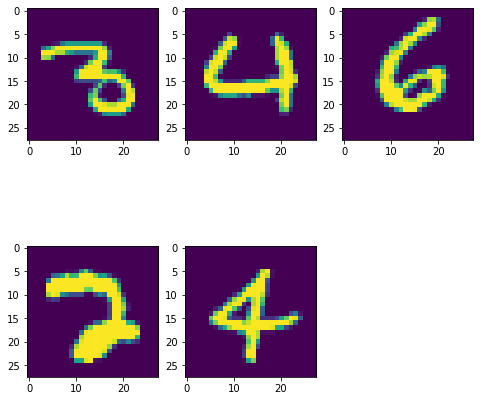

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTrainSet[30])
plt.subplot(232), plt.imshow(xTrainSet[60])
plt.subplot(233), plt.imshow(xTrainSet[90])
plt.subplot(234), plt.imshow(xTrainSet[120])
plt.subplot(235), plt.imshow(xTrainSet[150])

In [21]:
xTrain,xValidation,yTrain,yValidation = train_test_split(xTrainSet,yTrainSet,test_size=0.1)

xTrain = xTrain.reshape(54000,1,28,28)
xValidation = xValidation.reshape(6000,1,28,28)
xValidation = torch.from_numpy(xValidation)
xTrain = torch.from_numpy(xTrain)
yTrain = yTrain.astype(int)
yValidation = yValidation.astype(int)
yTrain = torch.from_numpy(yTrain)
yValidation = torch.from_numpy(yValidation)
print(xTrain.shape,yTrain.shape,xValidation.shape,yValidation.shape)

torch.Size([54000, 1, 28, 28]) torch.Size([54000]) torch.Size([6000, 1, 28, 28]) torch.Size([6000])


In [22]:
class Net(Module):

    def __init__(self):
        super().__init__()
        self.layers = Sequential(
            Conv2d(1,4,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            BatchNorm2d(4,eps=1e-05),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2),

            Conv2d(4,4,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            BatchNorm2d(4,eps=1e-05),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2)
        )

        self.linearLayers = Sequential(
            Linear(196,10)
        )

    def forward(self,x):
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        x = self.linearLayers(x)
        return x


In [23]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05)
lossFunc = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    lossFunc = lossFunc.cuda()
    
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearLayers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [24]:
trainLossList = []
validationLossList = []

def trainData(epoch):
    model.train()
    xTrainData,yTrainData = Variable(xTrain), Variable(yTrain)
    xValidationData, yValidationData = Variable(xValidation),Variable(yValidation)

    if torch.cuda.is_available():
        xTrainData = xTrainData.cuda()
        yTrainData = yTrainData.cuda()
        xValidationData = xValidationData.cuda()
        yValidationData =yValidationData.cuda()
    else:
        print("NO GPU")
    optimizer.zero_grad()

    yPredTrain = model(xTrainData)
    ypredValidation = model(xValidationData)

    trainLoss = lossFunc(yPredTrain,yTrainData)
    validationLoss = lossFunc(ypredValidation,yValidationData)
    trainLossList.append(trainLoss.cpu().detach().numpy())
    validationLossList.append(validationLoss.cpu().detach().numpy())

    trainLoss.backward()
    optimizer.step()
    trainLossSum = trainLoss.item()
    if epoch%2 == 0:
        print('Epoch: ',epoch+1,'\t','loss: ',validationLoss)



In [25]:
totalEpochs = 10

for epoch in range(totalEpochs):
    trainData(epoch)


NO GPU
Epoch:  1 	 loss:  tensor(2.4511, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  3 	 loss:  tensor(3.6469, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  5 	 loss:  tensor(2.4222, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  7 	 loss:  tensor(2.1611, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  9 	 loss:  tensor(1.5823, grad_fn=<NllLossBackward0>)
NO GPU


<function matplotlib.pyplot.show(close=None, block=None)>

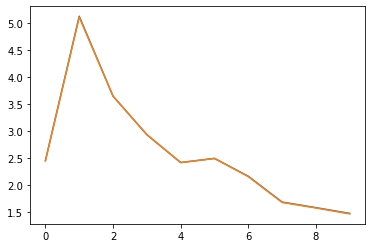

In [26]:
#plotting the losses
plt.plot(trainLossList,label = 'Training')
plt.plot(validationLossList,label='Validation')
plt.show

In [27]:
#Accuracy
def calcAccuracy(x,y):
    if torch.cuda.is_available():
        with torch.no_grad():
            yTrainPred = model(x.cuda())
            softmax = torch.exp(yTrainPred).cpu()
    
    else:
        yTrainPred = model(x)
        softmax = torch.exp(yTrainPred.detach())
        
    
    probability = list(softmax.numpy())
    predictions = np.argmax(probability, axis=1)
    # accuracy on training set
    return accuracy_score(y, predictions)


trainAccuracy = calcAccuracy(xTrain,yTrain)
validationAccuracy = calcAccuracy(xValidation,yValidation)

print("Train Accuracy= ",trainAccuracy)
print("Validation Accuracy= ",validationAccuracy)

Train Accuracy=  0.5007037037037037
Validation Accuracy=  0.5048333333333334


In [28]:
testSet = Dataset(test)
xTestSet = testSet.images
yTestSet = testSet.labels
xTestSet = xTestSet.reshape(10000,1,28,28)
xTestSet = torch.from_numpy(xTestSet)
print(xTestSet.shape)

torch.Size([10000, 1, 28, 28])


In [29]:
#Test set predicitons

if torch.cuda.is_available():
    with torch.no_grad():
        yTestPred = model(xTestSet.cuda())
        softmax = torch.exp(yTestPred).cpu()
else:
    yTestPred = model(xTestSet)
    softmax = torch.exp(yTestPred.detach())
    
probability = list(softmax.numpy())
predictions = np.argmax(probability, axis=1)

print(predictions)

[7 2 1 ... 9 8 6]
